In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


**EDA**

문장의 개수 : 46158문장
문장의 최대 길이 : 3469글자
문장의 평균 길이 : 63글자


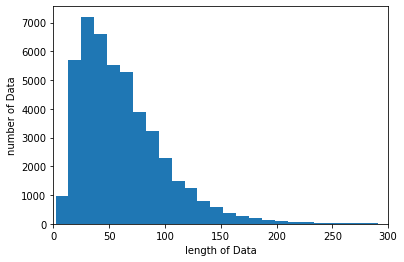

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

news_dataset = news_dataset.drop_duplicates()

print('문장의 개수 :', str(len(news_dataset))+'문장')
print('문장의 최대 길이 :', str(max(len(l) for l in news_dataset['content']))+'글자')
print('문장의 평균 길이 :', str(round(sum(map(len, news_dataset['content'])) / len(news_dataset['content'])))+'글자')

plt.hist([len(s) for s in news_dataset['content']], bins=300)
plt.xlim(0,300)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

**Data Preprocessing**

**MODEL**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


train_shape : (80734, 300) / (80734, 2)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 400)          26214400  
_________________________________________________________________
reshape_9 (Reshape)          (None, 300, 400, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 296, 1, 400)       800400    
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 400)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 3208      
_________________________________________________________________
activation_36 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_27 (Dr

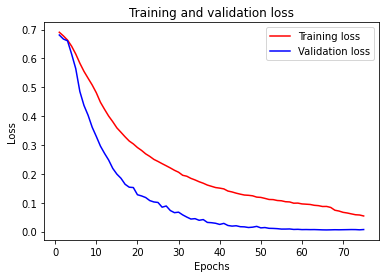

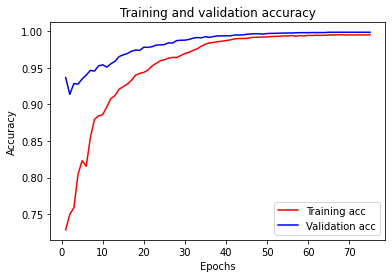

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Reshape, Conv2D, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder; LE = LabelEncoder()
from imblearn.over_sampling import RandomOverSampler

def convert_to_ord(data):
    try:
        return [ord(xx) for xx in data]
    except:
        print(data)

def conv2d_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=2**16, output_dim=output_dim, input_length=max_len))
    model.add(Reshape((max_len, output_dim, 1), input_shape=(max_len, output_dim)))
    model.add(Conv2D(filters=filters, kernel_size=(kernel_size, output_dim), strides=(1, 1), padding='valid'))
    model.add(GlobalMaxPooling2D())

    model.add(Dense(2**3))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2**3))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2**3))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=10)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history

if __name__ == "__main__":
    max_len = 300
    output_dim = 400
    filters = 400
    kernel_size = 5
    epochs = 2**10
    batch_size = 2**10

    news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

    news_dataset = pd.read_csv(news_dataset_path)

    del news_dataset["n_id"]
    del news_dataset["date"]
    del news_dataset["title"]
    del news_dataset["ord"]

    news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
    news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
    news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

    news_dataset = news_dataset.drop_duplicates()

    news_dataset['content'] = news_dataset['content'].map(convert_to_ord)
    news_dataset['info'] = LE.fit_transform(news_dataset['info'])

    x_train = sequence.pad_sequences(news_dataset['content'], maxlen=max_len)

    y_train = news_dataset['info']

    ros = RandomOverSampler(random_state=42)
    x_train, y_train = ros.fit_resample(x_train, news_dataset['info'])

    y_train = to_categorical(y_train)

    print('train_shape : {} / {}'.format(x_train.shape, y_train.shape))

    with tf.device('/device:GPU:0'):
        model, history = conv2d_cnn()

    model.save('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [73]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

def convert_to_ord(data):
    try:
        return [ord(xx) for xx in data]
    except:
        print(data)

news_dataset_test = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_test.csv")
del news_dataset_test["n_id"]
del news_dataset_test["date"]
del news_dataset_test["title"]
del news_dataset_test["ord"]

model = load_model('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5')

x_test = sequence.pad_sequences(news_dataset_test['content'].map(convert_to_ord), maxlen=300)

news_dataset_test["info"] = model.predict_classes(x_test)

print(news_dataset_test.groupby("info").size())

info
0    88169
1    54396
dtype: int64


In [74]:
news_dataset_train = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv")
del news_dataset_train["n_id"]
del news_dataset_train["date"]
del news_dataset_train["title"]
del news_dataset_train["ord"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="데이터에서 찾은 AI 속보"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]
news_dataset_train = news_dataset_train.drop_duplicates()

news_dataset_train = pd.DataFrame(news_dataset_train)

for i in range(len(news_dataset_test)):
    if len(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]) != 0:
        news_dataset_test.iloc[i,2] = int(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]["info"])

print(news_dataset_test.groupby("info").size())

info
0    88169
1    54396
dtype: int64


In [75]:
def g(x):
    if x["content"] == "데이터에서 찾은 AI 속보":
        return 1
    else:
        return x["info"]

news_dataset_test["info"] = news_dataset_test.apply(g, axis=1)

print(news_dataset_test.groupby("info").size())

info
0    88169
1    54396
dtype: int64


In [76]:
news_dataset_test = news_dataset_test[["id","info"]]

news_dataset_test.to_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/result/sample_submission.csv", index=False)